In [1]:
import os
import sys 
import glob
import dask
import pyproj
import pickle
import copy
import dask
import xsar
import xrft
import numpy as np
import scipy as sp
import pandas as pd
from pathlib import Path 
from matplotlib import pyplot as plt
import xarray as xr

import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from leakage.velocity_leakage import * #S1DopplerLeakage, add_dca_to_leakage_class, slant2ground, low_pass_filter_2D_dataset, low_pass_filter_2D
from leakage.misc import round_to_hour, angular_difference, calculate_distance, power_spectrum_custom

func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenario = 'Azores_20201127' # 'Aghulas_20200427'# 'Azores_20201127'
version = 'v1'
csv_file = f'../../data/leakage/temp/{scenario}_variables_perf_{version}.csv'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

In [3]:
test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='../../data/leakage/era5_winds/',
    resolution_product=50_000,
    az_footprint_cutoff=80_000,
    vx_sat=6800,
    PRF=4,
    grid_spacing=75,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern= 'phased_array', #'phased_array', sinc
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=35,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = 1,
    product_averaging_window='hann',
    # _gamma_hardcode = 
    # _interpolator = 'linear',
    # era5_smoothing_window=30,
    # denoise = True,
    # _pulsepair_noise = True
    # _speckle_noise= False
    )


/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:509: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


In [4]:
N_T_pp = 6 + 1 #-5
N_SNR = 1
# T_pps = np.logspace(-6, -4, N_T_pp)
T_pps = np.logspace(-6, -3.6, N_T_pp)
# T_pps = np.logspace(-5.2, -3.6, N_T_pp)
# T_pps = np.logspace(-4, -3.6, N_T_pp)
SNRs = 2**12#np.arange(N_SNR)
dB = lambda x: 10*np.log10(x)
T_corr_Doppler = 1E-4
T_corr_surface = 30E-3
  
file_path = Path(csv_file) 
if not file_path.exists(): 
    df = pd.DataFrame(columns=["index", "T_pp", "SNR", "rmse total", "rmse leakage", "rmse total post correction", "rmse leakage post correction", "rmse contribution from pp"])
    df.to_csv(csv_file, index = False)
else: 
    print(f"The file '{file_path}' already exists.") 
    df = pd.read_csv(csv_file)

df

The file '../../data/leakage/temp/Azores_20201127_variables_perf_v1.csv' already exists.


,index,T_pp,SNR,rmse total,rmse leakage,rmse total post correction,rmse leakage post correction,rmse contribution from pp
0,1.0,0.000001,1.0,204.981,1.203,204.987,0.419,201.055
1,2.0,0.000001,2.0,132.315,1.203,132.319,0.419,129.782
2,3.0,0.000001,4.0,88.762,1.203,88.764,0.419,87.062
3,4.0,0.000001,8.0,61.000,1.203,60.999,0.419,59.830
4,5.0,0.000001,16.0,42.503,1.203,42.497,0.419,41.682
...,...,...,...,...,...,...,...,...
72,73.0,0.000006,2048.0,1.517,1.203,1.023,0.419,0.918
73,74.0,0.000016,2048.0,1.421,1.203,0.872,0.419,0.753
74,75.0,0.000040,2048.0,1.409,1.203,0.853,0.419,0.732
75,76.0,0.000100,2048.0,1.441,1.203,0.905,0.419,0.790


In [5]:
input_T_pp = np.broadcast_to(T_pps, (N_SNR, N_T_pp)).T.ravel()
input_SNR = np.broadcast_to(SNRs, (N_T_pp, N_SNR)).ravel()

counter = df.index.stop
idx_start = df.index.stop

# for T_pp, SNR in zip(input_T_pp[idx_start:], input_SNR[idx_start:]):
for T_pp, SNR in zip(input_T_pp, input_SNR):
    counter += 1

    test.T_pp = T_pp
    test.SNR = SNR
    test.apply()

    net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
    net_velocity_error =  test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
    plot_cut = net_velocity_error / net_velocity_error

    fs_x = 1/test.grid_spacing
    fs_y = 1/test.stride
    V_pp_low_pass = low_pass_filter_2D(test.data.V_pp, 
                        cutoff_frequency= 1/test.resolution_product,
                        fs_x=fs_x,
                        fs_y=fs_y,
                        fill_nans = True)

    variables = [
        test.data.V_sigma_subscene * plot_cut,
        test.data.V_leakage_pulse_rg_subscene * plot_cut,
        test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted,
        net_leakage, 
        V_pp_low_pass
    ]

    rmses = [func_rmse(i) for i in variables]
    
    df = pd.read_csv(csv_file)
    df.loc[counter] = [counter, T_pp, SNR, *rmses]
    df.to_csv(csv_file, index = False)

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202011.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202011.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202011.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202011.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202011.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202011.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res75.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_wind_202011.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

In [11]:
df

,index,T_pp,SNR,rmse total,rmse leakage,rmse total post correction,rmse leakage post correction,rmse contribution from pp
0,1.0,0.000001,1.0,204.981,1.203,204.987,0.419,201.055
1,2.0,0.000001,2.0,132.315,1.203,132.319,0.419,129.782
2,3.0,0.000001,4.0,88.762,1.203,88.764,0.419,87.062
3,4.0,0.000001,8.0,61.000,1.203,60.999,0.419,59.830
4,5.0,0.000001,16.0,42.503,1.203,42.497,0.419,41.682
...,...,...,...,...,...,...,...,...
65,66.0,0.000006,1024.0,1.625,1.203,1.179,0.419,1.084
66,67.0,0.000016,1024.0,1.440,1.203,0.903,0.419,0.787
67,68.0,0.000040,1024.0,1.413,1.203,0.859,0.419,0.738
68,69.0,0.000100,1024.0,1.442,1.203,0.906,0.419,0.791


Text(0.5, 0, '$\\gamma \\ [-]$')

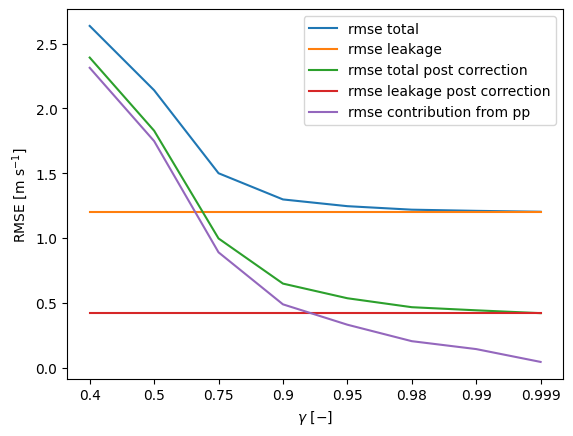

In [ ]:
# df.plot()
# plt.xlabel(gammas)
ax = df.plot()
ax.set_xticks(np.arange(0, 8))
ax.set_xticklabels(gammas)
ax.set_ylabel(r'${\rm RMSE}\ [\rm m\ s^{-1}]$')
ax.set_xlabel(r'$\gamma \ [-]$')

In [ ]:
rmses_all

[[2.636, 1.203, 2.392, 0.419, 2.313],
 [2.14, 1.203, 1.828, 0.419, 1.748],
 [1.5, 1.203, 0.997, 0.419, 0.89],
 [1.298, 1.203, 0.649, 0.419, 0.489],
 [1.246, 1.203, 0.536, 0.419, 0.332],
 [1.219, 1.203, 0.467, 0.419, 0.205],
 [1.21, 1.203, 0.443, 0.419, 0.144],
 [1.203, 1.203, 0.421, 0.419, 0.045]]